In [ ]:
import jax.numpy as np
from jax import random
from jax.experimental import stax
from jax.experimental.stax import BatchNorm, Dense, Flatten, Relu, Tanh, Sigmoid
from jax.experimental import optimizers
from jax.nn import initializers, leaky_relu
from jax.scipy.special import expit as sigmoid
from jax import lax
from jax import jit, grad, vmap

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torch
from torchvision import datasets, transforms

import numpy as onp
from tqdm import trange
import itertools
from functools import partial
import time 

In [ ]:
# Re-define stax convolution without biases and leaky relu with custom slope 
# (according to https://arxiv.org/pdf/1511.06434.pdf)
def GeneralConv(dimension_numbers, out_chan, filter_shape,
                strides=None, padding='VALID', W_init=None):
    """Layer construction function for a general convolution layer."""
    lhs_spec, rhs_spec, out_spec = dimension_numbers
    one = (1,) * len(filter_shape)
    strides = strides or one
    W_init = W_init or initializers.glorot_normal(rhs_spec.index('I'), rhs_spec.index('O'))
    def init_fun(rng, input_shape):
        filter_shape_iter = iter(filter_shape)
        kernel_shape = [out_chan if c == 'O' else
                        input_shape[lhs_spec.index('C')] if c == 'I' else
                        next(filter_shape_iter) for c in rhs_spec]
        output_shape = lax.conv_general_shape_tuple(
            input_shape, kernel_shape, strides, padding, dimension_numbers)
        bias_shape = [out_chan if c == 'C' else 1 for c in out_spec]
        W = W_init(rng, kernel_shape)
        return output_shape, W
    def apply_fun(params, inputs, **kwargs):
        W = params
        return lax.conv_general_dilated(inputs, W, strides, padding, one, one,
                                        dimension_numbers=dimension_numbers)
    return init_fun, apply_fun
Conv = partial(GeneralConv, ('NHWC', 'HWIO', 'NHWC'))

def GeneralConvTranspose(dimension_numbers, out_chan, filter_shape,
                         strides=None, padding='VALID', W_init=None):
    """Layer construction function for a general transposed-convolution layer."""
    lhs_spec, rhs_spec, out_spec = dimension_numbers
    one = (1,) * len(filter_shape)
    strides = strides or one
    W_init = W_init or initializers.glorot_normal(rhs_spec.index('I'), rhs_spec.index('O'))
    def init_fun(rng, input_shape):
        filter_shape_iter = iter(filter_shape)
        kernel_shape = [out_chan if c == 'O' else
                        input_shape[lhs_spec.index('C')] if c == 'I' else
                        next(filter_shape_iter) for c in rhs_spec]
        output_shape = lax.conv_transpose_shape_tuple(
            input_shape, kernel_shape, strides, padding, dimension_numbers)
        bias_shape = [out_chan if c == 'C' else 1 for c in out_spec]
        W = W_init(rng, kernel_shape)
        return output_shape, W
    def apply_fun(params, inputs, **kwargs):
        W = params
        return lax.conv_transpose(inputs, W, strides, padding,
                                  dimension_numbers=dimension_numbers)
    return init_fun, apply_fun
ConvTranspose = partial(GeneralConvTranspose, ('NHWC', 'HWIO', 'NHWC'))

def elementwise(fun, **fun_kwargs):
    """Layer that applies a scalar function elementwise on its inputs."""
    init_fun = lambda rng, input_shape: (input_shape, ())
    apply_fun = lambda params, inputs, **kwargs: fun(inputs, **fun_kwargs)
    return init_fun, apply_fun

LeakyRelu = elementwise(leaky_relu, negative_slope=0.2)

In [ ]:
# All weights need to be initialized as ~N(0, 0.02)
def Generator():
    init_fun, conv_net = stax.serial(ConvTranspose(out_chan=1024, filter_shape=(4, 4), strides=(1, 1), padding="VALID", W_init=initializers.normal(stddev=0.02)),
                                    BatchNorm(), 
                                    Relu,
                                    ConvTranspose(out_chan=512, filter_shape=(4, 4), strides=(2, 2), padding="SAME", W_init=initializers.normal(stddev=0.02)),
                                    BatchNorm(),
                                    Relu,
                                    ConvTranspose(out_chan=256, filter_shape=(4, 4), strides=(2, 2), padding="SAME", W_init=initializers.normal(stddev=0.02)),
                                    BatchNorm(), 
                                    Relu,
                                    ConvTranspose(out_chan=128, filter_shape=(4, 4), strides=(2, 2), padding="SAME", W_init=initializers.normal(stddev=0.02)),
                                    BatchNorm(),
                                    Relu,
                                    ConvTranspose(out_chan=1, filter_shape=(4, 4), strides=(2, 2), padding="SAME", W_init=initializers.normal(stddev=0.02)),
                                    Tanh)
    return init_fun, conv_net

def Discriminator():
    init_fun, conv_net = stax.serial(Conv(out_chan=128, filter_shape=(4, 4), strides=(2, 2), padding="SAME", W_init=initializers.normal(stddev=0.02)),
                                    LeakyRelu,
                                    Conv(out_chan=256, filter_shape=(4, 4), strides=(2, 2), padding="SAME", W_init=initializers.normal(stddev=0.02)),
                                    BatchNorm(),
                                    LeakyRelu,
                                    Conv(out_chan=512, filter_shape=(4, 4), strides=(2, 2), padding="SAME", W_init=initializers.normal(stddev=0.02)),
                                    BatchNorm(), 
                                    LeakyRelu,
                                    Conv(out_chan=1024, filter_shape=(4, 4), strides=(2, 2), padding="SAME", W_init=initializers.normal(stddev=0.02)),
                                    BatchNorm(),
                                    LeakyRelu,
                                    Conv(out_chan=1, filter_shape=(4, 4), strides=(1, 1), padding="VALID", W_init=initializers.normal(stddev=0.02)))
    return init_fun, conv_net

In [ ]:
@vmap
def bce_logits_loss(logit, label):
    return np.maximum(logit, 0) - logit * label + np.log(1.0 + np.exp(-np.abs(logit)))

In [ ]:
class DCGAN:
    # Initialize the class
    def __init__(self, init_key):

      # Set up network initialization and evaluation functions
      self.G_init, self.G_apply = Generator()
      self.D_init, self.D_apply = Discriminator()
      
      # Initialize parameters, not committing to a batch shape
      k1, k2 = random.split(init_key, 2)
      _, G_params = self.G_init(k1, (-1, 1, 1, 100))
      _, D_params = self.D_init(k2, (-1, 64, 64, 1))
                  
      # Use optimizers to set optimizer initialization and update functions
      self.G_opt_init, \
      self.G_opt_update, \
      self.G_get_params = optimizers.adam(2e-4, b1=0.5)
      self.G_opt_state = self.G_opt_init(G_params)

      self.D_opt_init, \
      self.D_opt_update, \
      self.D_get_params = optimizers.adam(2e-4, b1=0.5)
      self.D_opt_state = self.D_opt_init(D_params)

      # Logger
      self.G_itercount = itertools.count()
      self.D_itercount = itertools.count()
      self.batch_count = itertools.count()
      self.G_loss_log = []
      self.D_loss_log = [] 

    @partial(jit, static_argnums=(0,))
    def loss_G(self, G_params, D_params, batch):
        _, Z = batch
        # Generate fake image
        fake_image = self.G_apply(G_params, Z)
        # Evaluate discriminator output
        fake_logits = self.D_apply(D_params, fake_image)
        # The generator wants to fool the discriminator; that is, 
        # it wants the discriminator to assign high 
        # probability (close to 1) to the fake images it generates.
        loss = np.mean(bce_logits_loss(fake_logits, np.ones_like(fake_logits)))
        return loss

    @partial(jit, static_argnums=(0,))
    def loss_D(self, G_params, D_params, batch):
        X, Z = batch
        # Generate fake image
        fake_image = self.G_apply(G_params, Z)
        # Evaluate discriminator output
        real_logits = self.D_apply(D_params, X)
        fake_logits = self.D_apply(D_params, fake_image)
        # Losses
        real_loss = bce_logits_loss(real_logits, np.ones_like(real_logits))
        fake_loss = bce_logits_loss(fake_logits, np.zeros_like(fake_logits))
        loss = np.mean(real_loss + fake_loss)
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def G_step(self, i, G_opt_state, D_opt_state, batch):
        G_params = self.G_get_params(G_opt_state)
        D_params = self.D_get_params(D_opt_state)
        g = grad(self.loss_G, 0)(G_params, D_params, batch)
        return self.G_opt_update(i, g, G_opt_state)

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def D_step(self, i, G_opt_state, D_opt_state, batch):
        G_params = self.G_get_params(G_opt_state)
        D_params = self.D_get_params(D_opt_state)
        g = grad(self.loss_D, 1)(G_params, D_params, batch)
        return self.D_opt_update(i, g, D_opt_state)

    @partial(jit, static_argnums=(0,))
    def fetch_batch(self, rng_key, inputs):
        batch_size = inputs.shape[0]
        X = inputs.reshape(batch_size, 64, 64, 1) # Inputs need to be (batch_size, width, height, channels)
        Z = random.normal(rng_key, (batch_size, 1, 1, 100))
        return X, Z

    # Optimize parameters in a loop
    def train(self, train_loader, num_epochs = 20):
        pbar = range(num_epochs)
        for epoch in pbar:
            # Run epoch
            for batch_idx, (inputs, _) in enumerate(train_loader):
                k1, k2 = random.split(random.PRNGKey(next(self.batch_count)), 2)
                
                # Update discriminator
                batch = self.fetch_batch(k1, np.array(inputs))
                self.D_opt_state = self.D_step(next(self.D_itercount), 
                                                    self.G_opt_state, 
                                                    self.D_opt_state,
                                                    batch)
                # Update generator
                batch = self.fetch_batch(k2, np.array(inputs))
                self.G_opt_state = self.G_step(next(self.G_itercount), 
                                                    self.G_opt_state, 
                                                    self.D_opt_state,
                                                    batch)
                # if batch_idx % 50 == 0:
                #     print("epoch", epoch, "batch", batch_idx)
                #     G_params = self.G_get_params(self.G_opt_state)
                #     D_params = self.D_get_params(self.D_opt_state)
                #     loss_G = self.loss_G(G_params, D_params, batch)
                #     loss_D = self.loss_D(G_params, D_params, batch)
                #     print("loss_G", loss_G, "loss_D", loss_D)

            # Logger
            G_params = self.G_get_params(self.G_opt_state)
            D_params = self.D_get_params(self.D_opt_state)
            loss_G = self.loss_G(G_params, D_params, batch)
            loss_D = self.loss_D(G_params, D_params, batch)
            self.G_loss_log.append(loss_G)
            self.D_loss_log.append(loss_D)
            pbar.set_postfix({'Generator loss': loss_G, 'Discriminator loss': loss_D})

    @partial(jit, static_argnums=(0,))
    def generate(self, rng_key, G_params):
        Z = random.normal(rng_key, (1, 1, 1, 100))
        fake_image = self.G_apply(G_params, Z)
        return fake_image

In [ ]:
# Data_loader
img_size = 64
batch_size = 128

transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5), std=(0.5))
])
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# Initialize model
init_key = random.PRNGKey(0)
model = DCGAN(init_key)

In [ ]:
model.train(train_loader, num_epochs = 5)

epoch 0 batch 0
loss_G 3.6200285 loss_D 0.099777065
epoch 0 batch 50
loss_G 4.3076735 loss_D 0.326254
epoch 0 batch 100
loss_G 1.4756033 loss_D 0.6147264
epoch 0 batch 150
loss_G 0.81356525 loss_D 0.9603164
epoch 0 batch 200
loss_G 2.435968 loss_D 0.55985516
epoch 0 batch 250
loss_G 3.0888555 loss_D 0.4846943
epoch 0 batch 300
loss_G 1.9140736 loss_D 0.37077802
epoch 0 batch 350
loss_G 4.1591787 loss_D 1.1351691
epoch 0 batch 400
loss_G 2.7491345 loss_D 0.14937179
epoch 0 batch 450
loss_G 2.4770048 loss_D 0.14643025
epoch 1 batch 0
loss_G 8.769291 loss_D 5.7173853
epoch 1 batch 50
loss_G 0.77971566 loss_D 1.1956851
epoch 1 batch 100
loss_G 4.322681 loss_D 1.3818758
epoch 1 batch 150
loss_G 2.7830806 loss_D 0.44235975
epoch 1 batch 200
loss_G 3.25793 loss_D 0.1593033
epoch 1 batch 250
loss_G 3.5439448 loss_D 0.22083515
epoch 1 batch 300
loss_G 4.207341 loss_D 0.039850708
epoch 1 batch 350
loss_G 1.0999117 loss_D 0.7088837
epoch 1 batch 400
loss_G 3.2654324 loss_D 0.9974232
epoch 1 batch

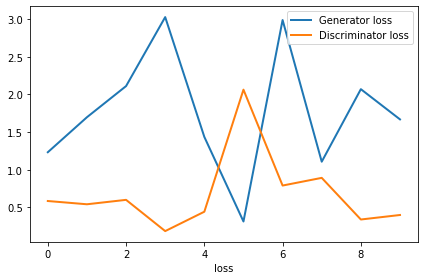

In [ ]:
plt.figure()
plt.plot(model.G_loss_log, lw = 2, label = 'Generator loss')
plt.plot(model.D_loss_log, lw = 2, label = 'Discriminator loss')
plt.legend()
plt.xlabel('epoch')
plt.xlabel('loss')
plt.tight_layout()

In [ ]:
# Generate some samples
num_samples = 128
Z = random.normal(random.PRNGKey(0), (num_samples, 1, 1, 100))
G_params = model.G_get_params(model.G_opt_state)
images = model.G_apply(G_params, Z)

(128, 64, 64, 1)


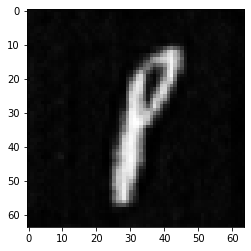

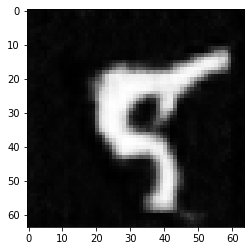

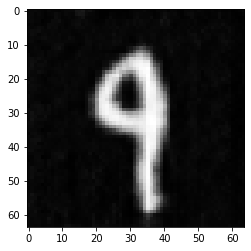

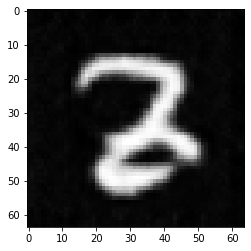

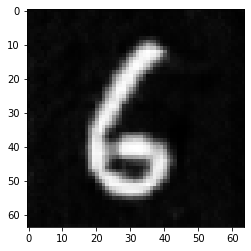

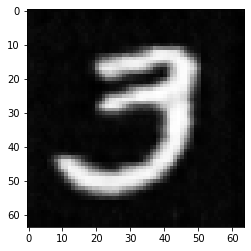

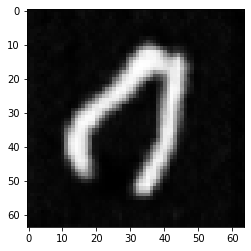

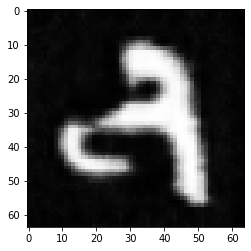

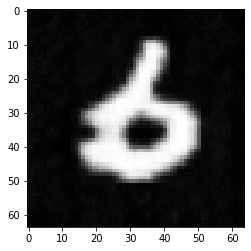

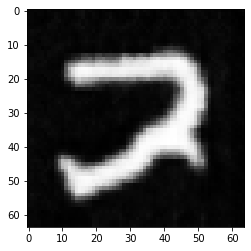

In [ ]:
# plot some samples
print(image.shape)
for k in range(10):
  fig = plt.figure(k)
  plt.imshow(images[k,:,:,0], cmap='gray')
  plt.show()